In [10]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from statsmodels.tsa.stattools import adfuller
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox

In [12]:
data = sm.datasets.get_rdataset("AirPassengers", "datasets").data
data

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121
...,...,...
139,1960.583333,606
140,1960.666667,508
141,1960.750000,461
142,1960.833333,390


Text(0, 0.5, 'Number of Air Passengers')

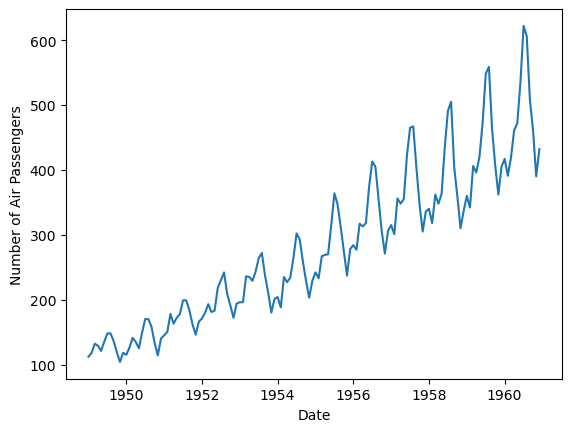

In [13]:
plt.plot(data['time'], data['value'])
plt.xlabel('Date')
plt.ylabel('Number of Air Passengers')

In [36]:
airp_seasonal_diff = np.diff(data['value'], n = 12)
ad_fuller_result = adfuller(airp_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -16.343415591661834
p-value: 2.9805039719043103e-29


With large negative ADF Statistic and a p-value<0.05 we reject H0 and consider data stationary.

In [19]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q, P, Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

The next snippet of code ran for quite a long time. Be aware :)

In [7]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = data['value'][:-12]

d = 0
D = 1
s = 12
warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packag

,"(p, q, P, Q)",AIC
0,"(2, 0, 1, 2)",903.465768
1,"(2, 0, 2, 1)",904.377306
2,"(1, 1, 1, 2)",904.480950
3,"(2, 0, 2, 2)",905.137423
4,"(2, 1, 1, 2)",905.271599
...,...,...
248,"(0, 0, 1, 0)",1110.241607
249,"(0, 0, 0, 3)",1128.638123
250,"(0, 0, 0, 2)",1128.851859
251,"(0, 0, 0, 1)",1157.168128


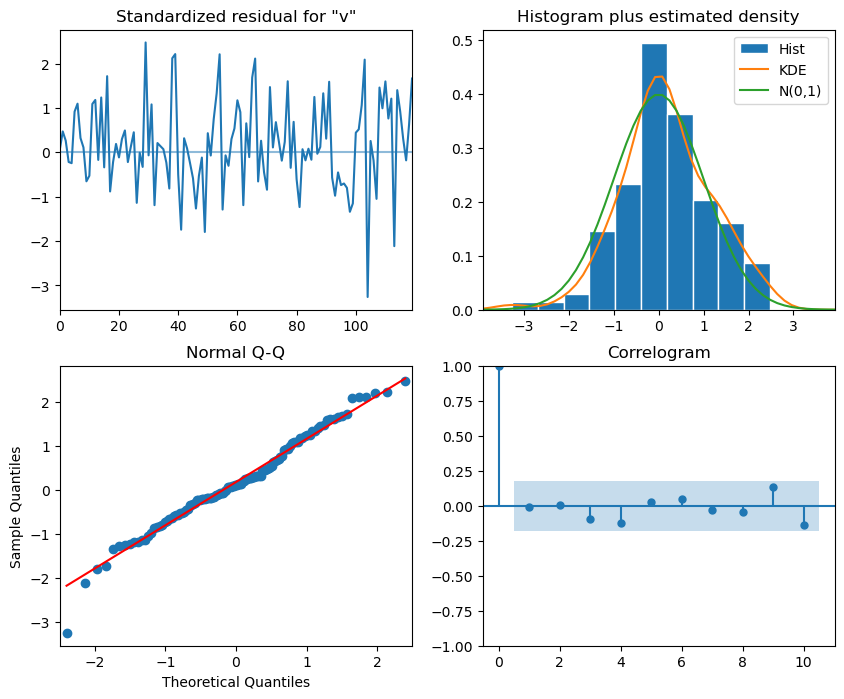

In [8]:
SARIMA_model = SARIMAX(
    train,
    order=(2, 0, 0),                 
    seasonal_order=(1, 1, 2, 12),     
    simple_differencing=False
)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

Great results. Let us check for independence.

In [9]:
residuals = SARIMA_model_fit.resid

lb_test_results = acorr_ljungbox(residuals, np.arange(1, 11, 1))

pvalues = lb_test_results['lb_pvalue']

print(pvalues>0.05)

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: lb_pvalue, dtype: bool


This indicates that data cannnot be modelled with SARIMA(2,0,0)(1,1,2)

Let us try to model via (2, 0, 2, 1)	904.377306

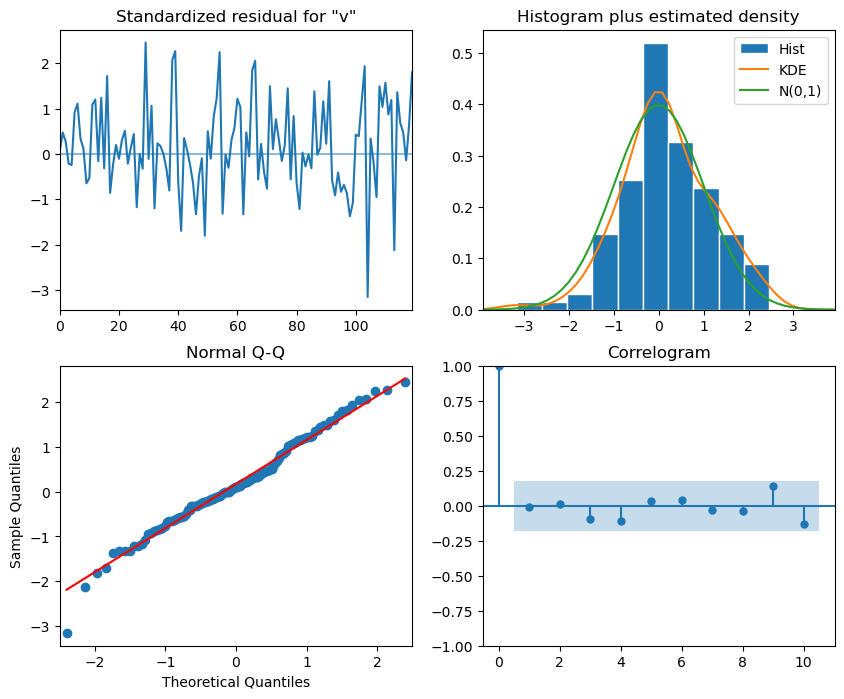

In [10]:
SARIMA_model2 = SARIMAX(
    train,
    order=(2, 0, 0),                 
    seasonal_order=(2, 1, 1, 12),     
    simple_differencing=False
)

SARIMA_model_fit2 = SARIMA_model2.fit(disp=False)
SARIMA_model_fit2.plot_diagnostics(figsize=(10, 8))
plt.show()

Again, good results.

In [11]:
residuals2 = SARIMA_model_fit2.resid

lb_test_results2 = acorr_ljungbox(residuals2, np.arange(1, 11, 1))

pvalues2 = lb_test_results2['lb_pvalue']

print(pvalues2>0.05)

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: lb_pvalue, dtype: bool


Unfortunately, we cannot forecast data with SARIMA(2,0,0)(2,1,1)

Let us try do log transformation first. 

In [21]:
data['log_value'] = np.log(data['value'])

Text(0, 0.5, 'Number of Air Passengers(log)')

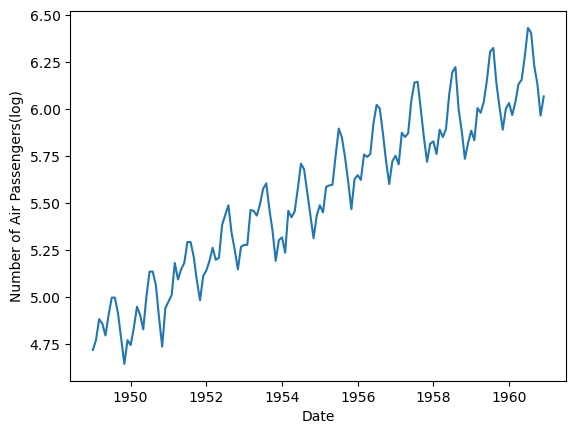

In [25]:
plt.plot(data['time'], data['log_value'])
plt.xlabel('Date')
plt.ylabel('Number of Air Passengers(log)')

In [27]:
airplog_seasonal_diff = np.diff(data['log_value'], n = 12)
ad_fuller_result = adfuller(airp_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.343415591661834
p-value: 2.9805039719043103e-29


With large negative ADF Statistic and a p-value<0.05 we reject H0 and consider data stationary. So, d = 0, D = 1

In [38]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train_log = data['log_value'][:-12]

d = 0
D = 1
s = 12
warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message = "Non-stationary starting autoregressive parameters")
SARIMA_result_df = optimize_SARIMA(train_log, SARIMA_order_list, d, D, s)
SARIMA_result_df


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ayany\anaconda3\Lib\site-packag

,"(p, q, P, Q)",AIC
0,"(1, 1, 1, 2)",-441.891628
1,"(3, 3, 0, 1)",-441.694188
2,"(1, 1, 0, 1)",-440.920946
3,"(2, 0, 1, 2)",-440.910502
4,"(1, 3, 0, 1)",-440.823081
...,...,...
251,"(0, 0, 1, 0)",-214.100392
252,"(0, 0, 0, 2)",-203.599803
253,"(0, 0, 0, 3)",-202.368493
254,"(0, 0, 0, 1)",-171.854731


As opposed to SARIMA(2,0,0)(2,1,1) and SARIMA(2,0,0)(1,1,2), the AIC suggests that for log transformed data we can use SARIMA(1,0,1)(1,1,2)

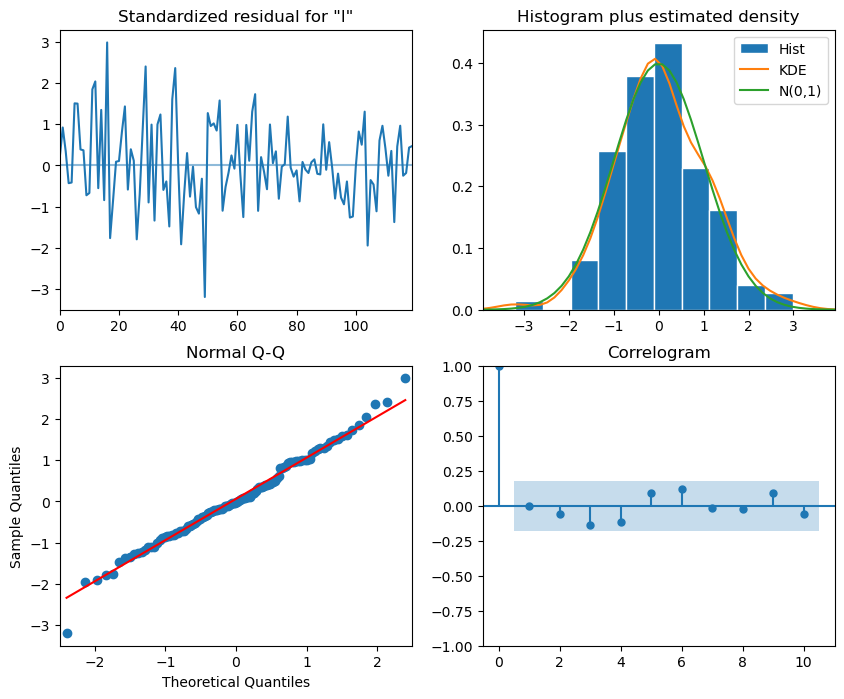

In [45]:
SARIMA_model_log = SARIMAX(
    train_log,
    order=(2, 0, 0),                 
    seasonal_order=(1, 1, 2, 12),     
    simple_differencing=False
)

SARIMA_model_fit_log = SARIMA_model_log.fit(disp=False)
SARIMA_model_fit_log.plot_diagnostics(figsize=(10, 8))
plt.show()

The results are good. We can see  the distribustion is close to normal. The correlogram shows no significance. Residuals show relatively stable variance

In [56]:
residuals_log = SARIMA_model_fit_log.resid

lb_test_results_log = acorr_ljungbox(residuals_log, np.arange(1, 11, 1))

pvalues_log = lb_test_results_log['lb_pvalue']

print(pvalues_log>0.05)

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: lb_pvalue, dtype: bool


So, we cannot forecat using SARIMA(1,0,1)(1,1,2) even after a log transform

Maybe too much differencing is applied, it could potentially over-difference the series, leading to negative effects on the residuals, such as introducing artificial noise. This might make the model fit worse, causing autocorrelation to remain in the residuals.

Also, even though the ADF test indicates stationarity, it's possible that the seasonal differencing has not fully removed the seasonal autocorrelation in the residuals. This means that there may still be patterns in the residuals at specific seasonal lags. The Ljung-Box test will pick up on these seasonal patterns, thus pointing on dependence.